# 🐾 Klasifikasi Suara Hewan Tiruan Menggunakan CNN
Model ini dikembangkan untuk mengenali suara tiruan hewan oleh manusia menggunakan file audio `.wav` dan model Convolutional Neural Network (CNN).

Kelas suara:
- 🐄 Cow – "moo"
- 🐈 Cat – "meow"
- 🐕 Dog – "woof"
- 🐐 Goat – "mbee"
- 🐦 Bird – "tweet"


In [1]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split


## 🎧 Ekstraksi Mel Spectrogram dari file audio
Kita menggunakan Mel Spectrogram karena lebih merepresentasikan cara telinga manusia menangkap suara.


In [2]:
def extract_features(file_path, max_len=128):
    y, sr = librosa.load(file_path, sr=22050)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_db = librosa.power_to_db(mel, ref=np.max)

    if mel_db.shape[1] < max_len:
        pad_width = max_len - mel_db.shape[1]
        mel_db = np.pad(mel_db, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mel_db = mel_db[:, :max_len]

    return mel_db


## 📁 Load dan proses dataset
Folder `dataset/` berisi subfolder `cow/`, `cat/`, `dog/`, `goat/`, `bird/`, masing-masing berisi file `.wav` suara tiruan.


In [3]:
data_dir = 'dataset'
labels = ['cow', 'cat', 'dog', 'goat', 'bird']

X = []
y = []

for label_idx, label in enumerate(labels):
    folder = os.path.join(data_dir, label)
    for filename in os.listdir(folder):
        if filename.endswith('.wav'):
            path = os.path.join(folder, filename)
            features = extract_features(path)
            X.append(features)
            y.append(label_idx)

X = np.array(X)
y = np.array(y)


## 🧹 Preprocessing untuk input CNN
Kita ubah shape menjadi 4D untuk CNN dan ubah label ke one-hot encoding.



In [4]:
X = X[..., np.newaxis]  # dari (n, 128, 128) ke (n, 128, 128, 1)
y = tf.keras.utils.to_categorical(y, num_classes=5)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


## 🧠 Arsitektur CNN
Model menggunakan dua Conv2D dan dua MaxPooling2D untuk ekstraksi fitur, lalu Dense Layer untuk klasifikasi.


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,389 (28.20 MB)

 Trainable params: 7,392,389 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

## 🏋️ Melatih Model
Latih model dengan data yang sudah diproses dan divalidasi.


In [6]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=8,
    validation_data=(X_val, y_val)
)


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 375ms/step - accuracy: 0.2344 - loss: 91.8322 - val_accuracy: 0.4000 - val_loss: 73.2625
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step - accuracy: 0.0406 - loss: 98.2522 - val_accuracy: 0.6000 - val_loss: 8.0374
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step - accuracy: 0.3375 - loss: 15.2521 - val_accuracy: 0.8000 - val_loss: 0.7935
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 255ms/step - accuracy: 0.5813 - loss: 1.0153 - val_accuracy: 1.0000 - val_loss: 0.1351
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step - accuracy: 1.0000 - loss: 0.1112 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step - accuracy: 0.9344 - loss: 0.1785 - val_accuracy: 1.0000 - val_loss: 0.0721
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step - accuracy: 0.7437 - loss: 0.6997 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 432ms/step - accuracy: 0.9281 - loss: 0.1208 - val_accuracy: 1.0000 - val_l

## 📊 Visualisasi Akurasi dan Loss
Bandingkan performa antara data training dan validasi.


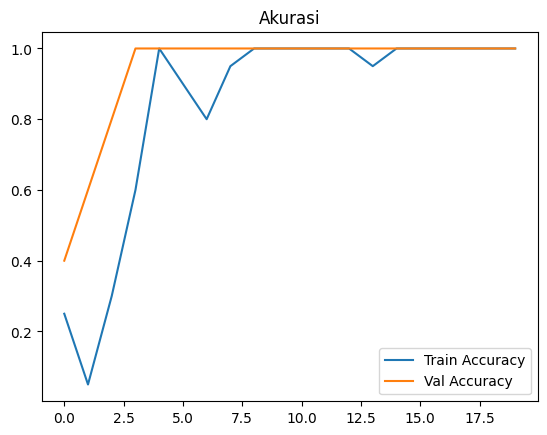

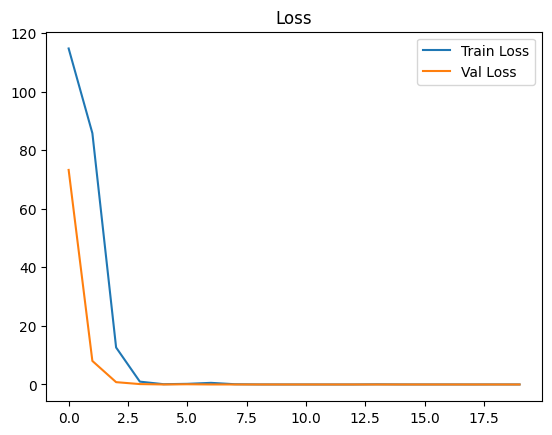

In [7]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Akurasi')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()
